In [1]:
# All includes

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd

import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# for svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC


# make color
import seaborn as sns
from matplotlib import cm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Import data

df = pd.read_excel('data.xlsx')

df = df.drop(columns=['Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23'])

#df.head()

In [3]:
# Prepare data

#df.columns

Feeding = df[['Feeding', 'Unnamed: 1', 'Unnamed: 2']]
Feeding = Feeding.dropna()
Feeding.index = pd.RangeIndex(len(Feeding.index))
Feeding = Feeding.drop(0)

Lying = df[['Lying', 'Unnamed: 4', 'Unnamed: 5']]
Lying = Lying.dropna()
Lying.index = pd.RangeIndex(len(Lying.index))
Lying = Lying.drop(0)

Standing = df[['Standing', 'Unnamed: 7', 'Unnamed: 8']]
Standing = Standing.dropna()
Standing.index = pd.RangeIndex(len(Standing.index))
Standing = Standing.drop(0)

Lying_down = df[['Lying down', 'Unnamed: 10', 'Unnamed: 11']]
Lying_down = Lying_down.dropna()
Lying_down.index = pd.RangeIndex(len(Lying_down.index))
Lying_down = Lying_down.drop(0)

Standing_up = df[['Feeding', 'Unnamed: 13', 'Unnamed: 14']]
Standing_up = Standing_up.dropna()
Standing_up.index = pd.RangeIndex(len(Standing_up.index))
Standing_up = Standing_up.drop(0)

Normal_walking = df[['Normal walking', 'Unnamed: 16', 'Unnamed: 17']]
Normal_walking = Normal_walking.dropna()
Normal_walking.index = pd.RangeIndex(len(Normal_walking.index))
Normal_walking = Normal_walking.drop(0)

Active_walking = df[['Active walking', 'Unnamed: 19', 'Unnamed: 20']]
Active_walking = Active_walking.dropna()
Active_walking.index = pd.RangeIndex(len(Active_walking.index))
Active_walking = Active_walking.drop(0)

#Active_walking.columns

In [4]:
#Standing.head(10)
# include lib for frequency domain features computations
from scipy import signal

In [5]:
## compute feature database
prepared_features = []
window_size = 6
stride = 3

# windowing and overlaping
#test_data = Standing.loc[15]

Feeding_data_list = [Feeding[i:i+window_size] for i in range(0, len(Feeding), stride) if i+window_size<=len(Feeding)]

Lying_data_list = [Lying[i:i+window_size] for i in range(0, len(Lying), stride) if i+window_size<=len(Lying)]

Lying_down_data_list = [Lying_down[i:i+window_size] for i in range(0, len(Lying_down), stride) if i+window_size<=len(Lying_down)]

Standing_data_list = [Standing[i:i+window_size] for i in range(0, len(Standing), stride) if i+window_size<=len(Standing)]

Standing_up_data_list = [Standing_up[i:i+window_size] for i in range(0, len(Standing_up), stride) if i+window_size<=len(Standing_up)]

Normal_walking_data_list = [Normal_walking[i:i+window_size] for i in range(0, len(Normal_walking), stride) if i+window_size<=len(Normal_walking)]

Active_walking_data_list = [Active_walking[i:i+window_size] for i in range(0, len(Active_walking), stride) if i+window_size<=len(Active_walking)]


In [80]:
# frequency features test

test_ = Feeding_data_list[1]
#Feeding_data_list[0]
test_data = np.array(test_.iloc[:, 0], dtype=np.float64)
test_data
# array([-0.8, -1.1, -0.8, -0.8, -0.8, -0.8]) --> test data


array([-0.8, -1.1, -0.8, -0.8, -0.8, -0.8])

In [66]:
# this function extract vector of features from raw data
# Expected features:
# 1. mean
# 2. median
# 3. variance
# 4. range
# 5. standard Deviation
# 6. average
# ---------------------------
# 7. energy
# 8. correlation
# 9. velocity
# 10. acceleration
# 11. fundamental frequencies (DFT)
# 12. signal peaks (using PSD - Power Spectral Density) 
# todo:...
# spectral peak features (12 per channel): value and freq of first 6 peaks
# for each chanel: x,  y, z:
# ---> expecting to extract 12 features:
# features  1-6: position of the highest 6 peaks
# features 7-12: power levels of the highest 6 peaks

# return feat: a numpy array of length 18 <todo>

def featuresFromBuffer(at, fs):
    feat = np.zeros(33)
    #feat = []
    x = np.array(at.iloc[0], dtype=np.float64)   # x acceleration component
    y = np.array(at.iloc[1], dtype=np.float64)   # y
    z = np.array(at.iloc[2], dtype=np.float64)   # z
    print(len(x))
    # Average value in signal buffer for all three acceleration components (1 each)    
    means = [np.mean(i) for i in [x, y, z]]
    feat[0:3] = means
    
    # RMS value in signal buffer for all three acceleration components (1 each)
    rms = [np.sqrt(np.mean(i**2)) for i in [x, y, z]]
    feat[3:6] = rms
    
    # Standard deviation
    std = [np.std(i) for i in [x, y, z]]
    feat[6:9] = std
    
    # Variance
    var = [np.var(i) for i in [x, y, z]]
    feat[9:12] = var
    
    # Median
    med = [np.median(i) for i in [x, y, z]]
    feat[12:15] = med
    
    # Range
    #Range1 = [ np.amin(i) for i in [x, y, z]]    
    #feat[33:36] = Range1
    #Range2 = [ np.amax(i) for i in [x, y, z]]    
    #feat[36:39] = Range2
    
    # Energy
    #energy = [ sum(i**2) for i in [x, y, z]]
    #feat[39:42] = energy
    
    #ranges = np.array(Range)
    #feat[15:18] = ranges
    # TODO:
    
    # Power Spectral Density
    psd = []
    for i in [x, y, z]:
        f, p = signal.welch(i)
        psd.append(p)
    feat[15:33]
    
    # Spectral peak features
    # Spectral power features
    # Autocorrelation features
    
    return feat
    

In [78]:
test2 = Feeding_data_list[0]
test2
t2 = test2.iloc[:,0]
t2
#f2 = featuresFromBuffer(test2, 5)


Feeding Unnamed: 1 Unnamed: 2
1    -0.8        0.2        0.2
2    -0.9        0.1        0.2
3    -0.9          0        0.3
4    -0.8       -0.1        0.4
5    -1.1       -0.2        0.5
6    -0.8        0.1        0.3

1   -0.8
2   -0.9
3   -0.9
4   -0.8
5   -1.1
6   -0.8
Name: Feeding, dtype: object

In [8]:
#f = []
#f1 = [1, 2]
#f [0:1] = f1
#f

In [9]:
#f = []
x1 = np.array([1, 1, 1, 1])
x2 = np.array([3, 4, 6, 7])
x3 = np.array([3, 7, 8, 30])
f = [ sum(i**2) for i in [x1, x2, x3]]
f
#type(f)
#Ra[0:3] = f
#type(Ra)

[4, 110, 1022]

In [14]:
## Definitons:
# Feeding: 1
# Lying: 2
# Standing: 3
# Lying down: 4
# Standing up: 5
# Normal walking: 6
# Active walking: 7

#data = [Feeding, Lying, Standing, Lying_down, Standing, Lying_down, Standing_up, Normal_walking, Active_walking]
# features_vector is a list of numpy arrays
features_vector = []

lables = []

#len(Feeding_data_list)
#Feeding_data_list[1226]
#Feeding

In [15]:
print("begin->end")
# main loop of data preparation
i = 0

# Add Feeding feature and lable = 1
for action in Feeding_data_list:
    feat = featuresFromBuffer(action, 5)
    features_vector.append(feat)
    lables.append(1)

# Add Lying feature and lable = 2
for action in Lying_data_list:
    feat = featuresFromBuffer(action, 5)
    features_vector.append(feat)
    lables.append(2)
    
# Add Standing feature and lable = 3
for action in Standing_data_list:
    feat = featuresFromBuffer(action, 5)
    features_vector.append(feat)
    lables.append(3)
    
# Add Lying_down feature and lable = 4
for action in Lying_down_data_list:
    feat = featuresFromBuffer(action, 5)
    features_vector.append(feat)
    lables.append(4)
    
# Add Standing_up feature and lable = 5
for action in Standing_up_data_list:
    feat = featuresFromBuffer(action, 5)
    features_vector.append(feat)
    lables.append(5)
    
# Add Normal_walking feature and lable = 6
for action in Normal_walking_data_list:
    feat = featuresFromBuffer(action, 5)
    features_vector.append(feat)
    lables.append(6)
    
# Add Active_walking feature and lable = 7
for action in Active_walking_data_list:
    feat = featuresFromBuffer(action, 5)
    features_vector.append(feat)
    lables.append(7)

    
    

begin->end


/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/s

In [16]:
# everything after this line is totally useless ...

len(features_vector)

len(lables)

7363

7363

In [21]:
import plotly 
plotly.tools.set_credentials_file(username='luongtd21', api_key='46dmgkalPEZqRnbKFEBk')

In [22]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF

import numpy as np
import pandas as pd
import scipy
import peakutils

In [47]:
test_data = Feeding_data_list[1]
test_data
#Feeding_data_list[0]
t1 = np.array(test_data.iloc[0], dtype=np.float64)
t1

Feeding Unnamed: 1 Unnamed: 2
4    -0.8       -0.1        0.4
5    -1.1       -0.2        0.5
6    -0.8        0.1        0.3
7    -0.8        0.1        0.3
8    -0.8        0.1        0.3
9    -0.8        0.1        0.3

array([-0.8, -0.1,  0.4])

In [27]:
milk_data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/monthly-milk-production-pounds.csv')
time_series = milk_data['Monthly milk production (pounds per cow)']
time_series = time_series.tolist()

df = milk_data[0:15]
time_series
milk_data
#table = FF.create_table(df)
#py.iplot(table, filename='milk-production-dataframe')


[589,
 561,
 640,
 656,
 727,
 697,
 640,
 599,
 568,
 577,
 553,
 582,
 600,
 566,
 653,
 673,
 742,
 716,
 660,
 617,
 583,
 587,
 565,
 598,
 628,
 618,
 688,
 705,
 770,
 736,
 678,
 639,
 604,
 611,
 594,
 634,
 658,
 622,
 709,
 722,
 782,
 756,
 702,
 653,
 615,
 621,
 602,
 635,
 677,
 635,
 736,
 755,
 811,
 798,
 735,
 697,
 661,
 667,
 645,
 688,
 713,
 667,
 762,
 784,
 837,
 817,
 767,
 722,
 681,
 687,
 660,
 698,
 717,
 696,
 775,
 796,
 858,
 826,
 783,
 740,
 701,
 706,
 677,
 711,
 734,
 690,
 785,
 805,
 871,
 845,
 801,
 764,
 725,
 723,
 690,
 734,
 750,
 707,
 807,
 824,
 886,
 859,
 819,
 783,
 740,
 747,
 711,
 751,
 804,
 756,
 860,
 878,
 942,
 913,
 869,
 834,
 790,
 800,
 763,
 800,
 826,
 799,
 890,
 900,
 961,
 935,
 894,
 855,
 809,
 810,
 766,
 805,
 821,
 773,
 883,
 898,
 957,
 924,
 881,
 837,
 784,
 791,
 760,
 802,
 828,
 778,
 889,
 902,
 969,
 947,
 908,
 867,
 815,
 812,
 773,
 813,
 834,
 782,
 892,
 903,
 966,
 937,
 896,
 858,
 817,
 827,
 797

Month  Monthly milk production (pounds per cow)
0    1962-01                                       589
1    1962-02                                       561
2    1962-03                                       640
3    1962-04                                       656
4    1962-05                                       727
5    1962-06                                       697
6    1962-07                                       640
7    1962-08                                       599
8    1962-09                                       568
9    1962-10                                       577
10   1962-11                                       553
11   1962-12                                       582
12   1963-01                                       600
13   1963-02                                       566
14   1963-03                                       653
15   1963-04                                       673
16   1963-05                                       742
17   1963-06                                       716
18   1963-07                                       660
19   1963-08                                       617
20   1963-09                                       583
21   1963-10                                       587
22   1963-11                                       565
23   1963-12                                       598
24   1964-01                                       628
25   1964-02                                       618
26   1964-03                                       688
27   1964-04                                       705
28   1964-05                                       770
29   1964-06                                       736
..       ...                                       ...
138  1973-07                                       881
139  1973-08                                       837
140  1973-09                                       784
141  1973-10                                       791
142  1973-11                                       760
143  1973-12                                       802
144  1974-01                                       828
145  1974-02                                       778
146  1974-03                                       889
147  1974-04                                       902
148  1974-05                                       969
149  1974-06                                       947
150  1974-07                                       908
151  1974-08                                       867
152  1974-09                                       815
153  1974-10                                       812
154  1974-11                                       773
155  1974-12                                       813
156  1975-01                                       834
157  1975-02                                       782
158  1975-03                                       892
159  1975-04                                       903
160  1975-05                                       966
161  1975-06                                       937
162  1975-07                                       896
163  1975-08                                       858
164  1975-09                                       817
165  1975-10                                       827
166  1975-11                                       797
167  1975-12                                       843

[168 rows x 2 columns]

In [30]:
Fs = 150.0;  # sampling rate
Ts = 1.0/Fs; # sampling interval
t = np.arange(0,1,Ts) # time vector

ff = 5;   # frequency of the signal
y = np.sin(2*np.pi*ff*t)

n = len(y) # length of the signal
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(int(n/2))] # one side frequency range

Y = np.fft.fft(y)/n # fft computing and normalization
Y = Y[range(int(n/2))]

fig, ax = plt.subplots(2, 1)
ax[0].plot(t,y)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[1].plot(frq,abs(Y),'r') # plotting the spectrum
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|Y(freq)|')

plot_url = py.plot_mpl(fig, filename='mpl-basic-fft')


Text(0.5, 0, 'Time')

Text(0, 0.5, 'Amplitude')

Text(0.5, 0, 'Freq (Hz)')

Text(0, 0.5, '|Y(freq)|')

In [31]:
Y

array([ 8.25379164e-17+0.00000000e+00j,  3.58736101e-19-2.96059473e-18j,
        8.73462372e-17-5.55064753e-18j,  2.14649463e-18+7.48125364e-17j,
       -1.13153804e-16-5.52165948e-17j,  2.12173156e-16-5.00000000e-01j,
       -1.29810639e-17+6.32513126e-17j,  2.93864220e-17+4.73620587e-17j,
       -3.00219698e-17+3.89237735e-17j, -9.35985813e-18-1.03349505e-18j,
       -1.88791237e-17+1.21578545e-18j, -5.01112192e-18-1.85945282e-17j,
        1.59458227e-16-1.51917551e-17j, -4.90224077e-17+1.34428829e-16j,
       -9.81203339e-17+3.59081624e-17j,  2.99599490e-17-2.06924932e-17j,
       -1.76547268e-17-3.37165044e-17j,  4.57905283e-17-6.90491249e-18j,
        1.05704398e-17+8.05758462e-17j, -9.29072790e-18+5.29625678e-17j,
       -1.02062260e-16-7.02090097e-18j, -4.70945056e-17-3.91327360e-17j,
        8.14216131e-17-1.08985267e-17j, -8.13973089e-17+9.89809497e-18j,
        1.78572823e-17+1.82510688e-17j, -1.57094196e-17-4.73695157e-17j,
        9.68352064e-19+1.22618320e-17j, -1.61937166

'\nPlots a Single-Sided Amplitude Spectrum of y(t)\n'

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Amplitude')

TypeError: 'float' object cannot be interpreted as an integer

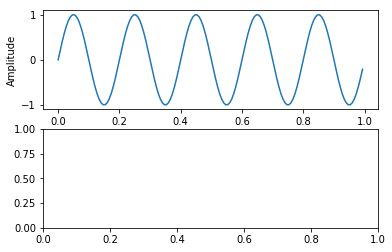

In [20]:
from numpy import sin, linspace, pi
from pylab import plot, show, title, xlabel, ylabel, subplot
from scipy import fft, arange


"""
Plots a Single-Sided Amplitude Spectrum of y(t)
"""
def plotSpectrum(y,Fs):
    n = len(y) # length of the signal
    k = arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(n/2)] # one side frequency range

    Y = fft(y)/n # fft computing and normalization
    Y = Y[range(n/2)]

    plot(frq,abs(Y),'r') # plotting the spectrum
    xlabel('Freq (Hz)')
    ylabel('|Y(freq)|')
    
Fs = 150.0;  # sampling rate
Ts = 1.0/Fs; # sampling interval
t = arange(0,1,Ts) # time vector

ff = 5;   # frequency of the signal
y = sin(2*pi*ff*t)

subplot(2,1,1)
plot(t,y)
xlabel('Time')
ylabel('Amplitude')
subplot(2,1,2)
plotSpectrum(y,Fs)
show()

In [36]:
X_train, X_test,y_train, y_test = train_test_split(features_vector, lables, random_state=0)
classifier=SVC()

parameters=[{'kernel': ['rbf'], 'gamma': [0.001, 0.0001], 'C': [1, 10, 100, 1000]}]


In [37]:
model=GridSearchCV(classifier,parameters,n_jobs=-1,cv=4,verbose=4)
model.fit(X_train, y_train)
#print("\nAccuracy on training set: {:.2f}".format(clf.score(X_train, y_train)))
#print("\nAccuracy on test set: {:.2f}".format(clf.score(X_test, y_test)))
#title = 'Linear SVC, C = {:.3f}'.format(this_C)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   33.9s finished


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'kernel': ['rbf'], 'gamma': [0.001, 0.0001], 'C': [1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=4)

In [38]:
y_pred=model.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)
print( 'Best Parameters: '+ str(model.best_params_) )
print( 'Accuracy Score: '+ str(accuracy*100) + ' %' )

Best Parameters: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
Accuracy Score: 74.47039652362847 %


In [39]:
# prepare data train;
X_train, X_test,y_train, y_test = train_test_split(features_vector, lables, random_state=0)

this_C = 100
clf = SVC(C=this_C).fit(X_train, y_train)
print("\nAccuracy on training set: {:.2f}".format(clf.score(X_train, y_train)))
print("\nAccuracy on test set: {:.2f}".format(clf.score(X_test, y_test)))
#title = 'Linear SVC, C = {:.3f}'.format(this_C)
#plot_class_regions_for_classifier_subplot(clf, X_train, y_train, None, None, title, subaxes)
# Multi-class classification with linear models

/home/kikyou/.local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



Accuracy on training set: 0.81

Accuracy on test set: 0.78


In [84]:
len(X_test)
len(y_train)

1841

5522

<Figure size 1080x720 with 0 Axes>

Text(0.5, 1.0, 'SVM rbf Kernel \nAccuracy:0.775')

Text(114.0, 0.5, 'True label')

Text(0.5, 69.0, 'Predicted label')

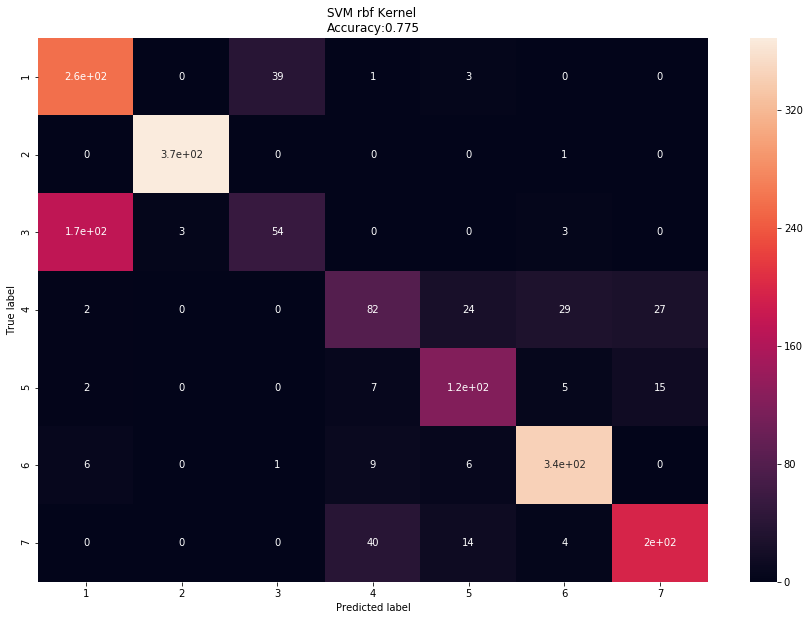

In [111]:
# confusion matrices:
svm_predicted = clf.predict(X_test)


confusion_test = confusion_matrix(y_test, svm_predicted)


df_cm = pd.DataFrame(confusion_test,
                    index = [i for i in range(1, 8)], columns = [i for i in range(1, 8)])


plt.figure(figsize=(15,10))

sns.heatmap(df_cm, annot=True)

plt.title('SVM rbf Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, 
                                                                       svm_predicted)))
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [65]:
print(classification_report(y_test, svm_predicted))

              precision    recall  f1-score   support

           1       0.59      0.84      0.69       301
           2       0.99      1.00      1.00       370
           3       0.56      0.27      0.36       234
           4       0.54      0.49      0.51       164
           5       0.77      0.82      0.79       151
           6       0.90      0.93      0.91       366
           7       0.79      0.75      0.77       255

   micro avg       0.77      0.77      0.77      1841
   macro avg       0.74      0.73      0.72      1841
weighted avg       0.77      0.77      0.76      1841



In [397]:
## Definitons:
# Feeding: 1
# Lying: 2
# Standing: 3
# Lying down: 4
# Standing up: 5
# Normal walking: 6
# Active walking: 7